<a href="https://colab.research.google.com/github/AngelTroncoso/ML_taxis_Amarillos/blob/main/Machine_Learning_para_Taxis_Amarillos_de_Nueva_York_(2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

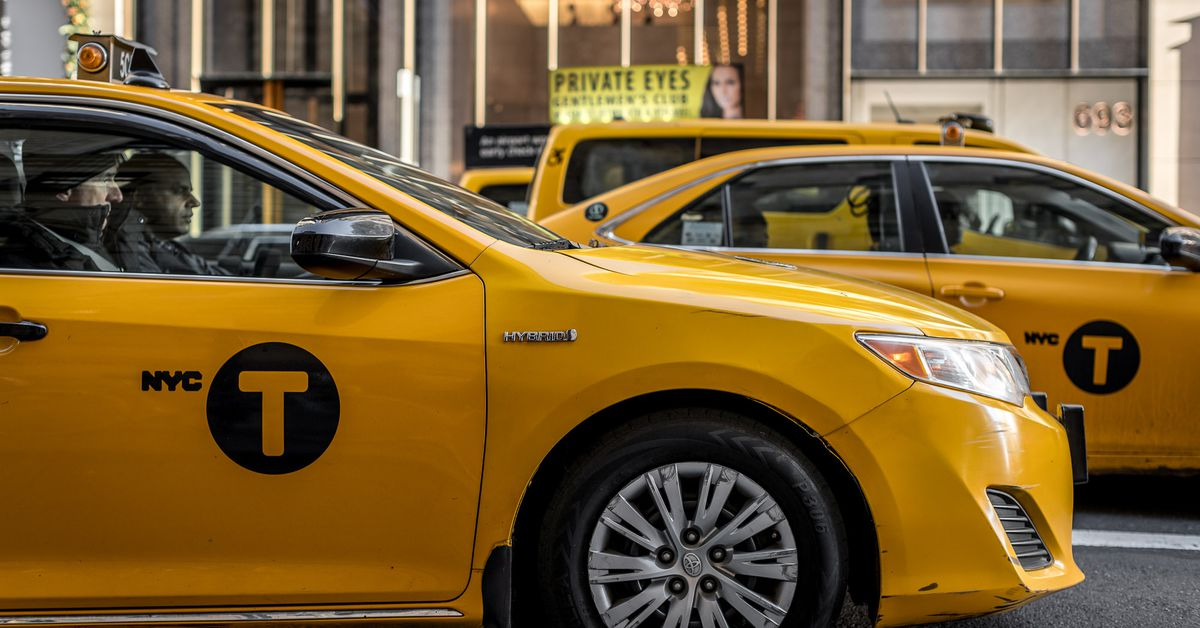

¡Hola! ✨

Soy Cynthia Castillo — también conocida como La Matemaga. Soy analista de datos y educadora, con experiencia en banca, salud y tecnología. Mi especialidad es el análisis de datos, aunque también he explorado áreas como machine learning, LLMs y data engineering.

He trabajado con herramientas como Power BI, Looker Studio, Snowflake y Databricks, colaborando con equipos multidisciplinarios para convertir datos en decisiones de impacto. Más allá del trabajo técnico, mentoreo a personas que quieren crecer en el mundo de datos, a través de talleres, bootcamps y charlas comunitarias.

Para más contenido, sígueme en mis redes sociales :) Espero te guste tanto este notebook como yo disfruté construyéndolo.

<p>
  <a href="https://www.x.com/LaMatemaga" target="_blank">
    <img src=https://img.shields.io/twitter/follow/LaMatemaga?style=social&logo=twitter" />
  </a>
  <a href="https://github.com/LaMatemaga" target="_blank">
    <img src=https://img.shields.io/badge/github-%2324292e.svg?&style=flat-square&logo=github&logoColor=white alt=github style="margin-bottom: 5px;" />
  </a>
  <a href="https://linkedin.com/in/LaMatemaga" target="_blank">
    <img src=https://img.shields.io/badge/linkedin-%231E77B5.svg?&style=flat-square&logo=linkedin&logoColor=white alt=linkedin style="margin-bottom: 5px;" />
  </a>
  <a href="https://www.kaggle.com/LaMatemaga" target="_blank">
    <img src=https://img.shields.io/badge/kaggle-%2344BAE8.svg?&style=flat-square&logo=kaggle&logoColor=white alt=kaggle style="margin-bottom: 5px;" />
  </a>

  <br>
  <img alt="Twitch Status" src="https://img.shields.io/twitch/status/LaMatemaga?style=social">
  <img alt="YouTube Channel Subscribers" src="https://img.shields.io/youtube/channel/subscribers/UCOxOlmUM93jYts1AWYdWJVA?style=social">
</p>

# Machine Learning para Taxis Amarillos de Nueva York (2024)

In [ ]:
# !pip install

## Librerías Necesarias

In [1]:
#@markdown Importación de librerías esenciales y configuraciones del Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                           accuracy_score, precision_score, recall_score,
                           f1_score, classification_report, confusion_matrix)

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## ETL previo al Machine Learning

### Carga y Exploración de Datos

In [2]:
# URL base para los datos de 2024
base_url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-{:02d}.parquet'

In [3]:
#@markdown Función para cargar datos de múltiples meses
def load_taxi_data(months=None):
    """
    Carga datos de taxis amarillos de NYC para los meses especificados
    """
    if months is None:
        months = range(1, 13)  # Todos los meses del 2024

    dataframes = []
    for month in months:
        try:
            url = base_url.format(month)
            df_month = pd.read_parquet(url)
            df_month['month'] = month
            dataframes.append(df_month)
            print(f"✓ Cargado mes {month}: {len(df_month)} registros")
        except Exception as e:
            print(f"✗ Error cargando mes {month}: {e}")

    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

Cargamos los datos (empezamos con 3 meses para optimizar el procesamiento)

In [4]:
print("Cargando datos de taxis amarillos NYC 2024...")
df = load_taxi_data(months=[1, 2, 3])
print(f"\nDataset final: {df.shape[0]} filas, {df.shape[1]} columnas")

Cargando datos de taxis amarillos NYC 2024...
✓ Cargado mes 1: 2964624 registros
✓ Cargado mes 2: 3007526 registros
✓ Cargado mes 3: 3582628 registros

Dataset final: 9554778 filas, 20 columnas


### Análisis Exploratorio de Datos (EDA)

Información básica del dataset

In [5]:
print("=== INFORMACIÓN BÁSICA ===")
print(df.info())
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())

=== INFORMACIÓN BÁSICA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9554778 entries, 0 to 9554777
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       


Verificar valores faltantes

In [6]:
print("\n=== VALORES FALTANTES ===")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])


=== VALORES FALTANTES ===
passenger_count         751962
RatecodeID              751962
store_and_fwd_flag      751962
congestion_surcharge    751962
Airport_fee             751962
dtype: int64


Visualización de distribuciones principales

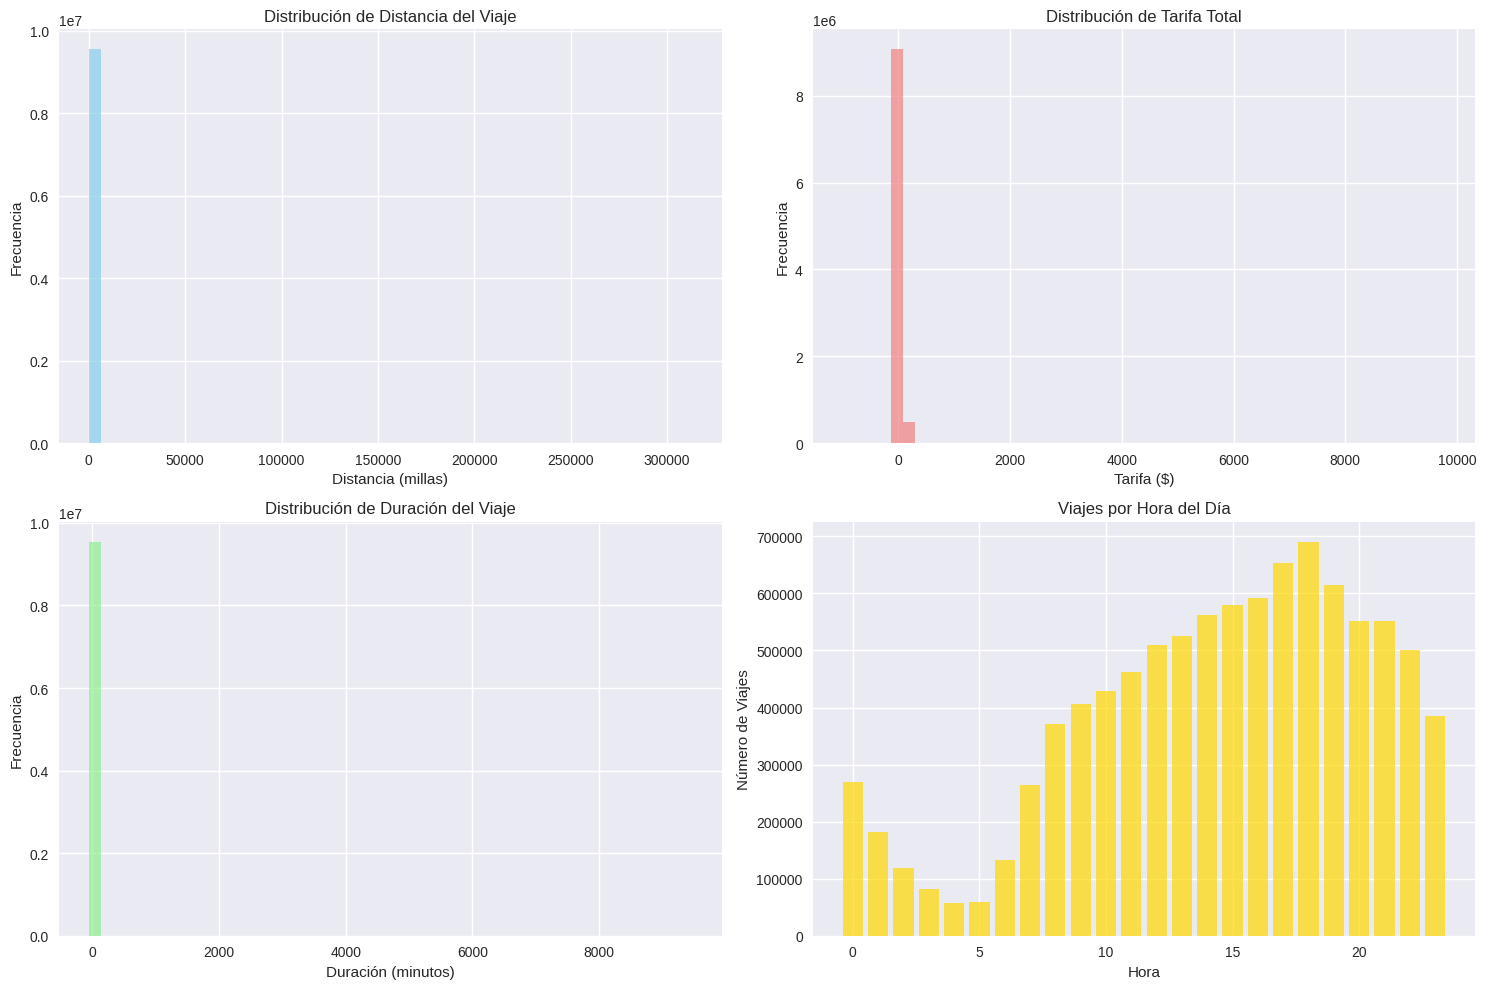

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de distancia del viaje
axes[0,0].hist(df['trip_distance'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribución de Distancia del Viaje')
axes[0,0].set_xlabel('Distancia (millas)')
axes[0,0].set_ylabel('Frecuencia')

# Distribución de tarifa total
axes[0,1].hist(df['total_amount'], bins=50, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Distribución de Tarifa Total')
axes[0,1].set_xlabel('Tarifa ($)')
axes[0,1].set_ylabel('Frecuencia')

# Distribución de duración del viaje
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
axes[1,0].hist(df['trip_duration'], bins=50, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Distribución de Duración del Viaje')
axes[1,0].set_xlabel('Duración (minutos)')
axes[1,0].set_ylabel('Frecuencia')

# Viajes por hora del día
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
hourly_trips = df.groupby('pickup_hour').size()
axes[1,1].bar(hourly_trips.index, hourly_trips.values, alpha=0.7, color='gold')
axes[1,1].set_title('Viajes por Hora del Día')
axes[1,1].set_xlabel('Hora')
axes[1,1].set_ylabel('Número de Viajes')

plt.tight_layout()
plt.show()

### Feature Engineering

In [8]:
def create_features(df):
    """
    Función para crear nuevas características del dataset
    """
    df_features = df.copy()

    # Características temporales
    df_features['pickup_hour'] = df_features['tpep_pickup_datetime'].dt.hour
    df_features['pickup_day'] = df_features['tpep_pickup_datetime'].dt.day
    df_features['pickup_month'] = df_features['tpep_pickup_datetime'].dt.month
    df_features['pickup_weekday'] = df_features['tpep_pickup_datetime'].dt.weekday
    df_features['pickup_weekend'] = (df_features['pickup_weekday'] >= 5).astype(int)

    # Características del viaje
    df_features['trip_duration'] = (df_features['tpep_dropoff_datetime'] -
                                   df_features['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Velocidad promedio (millas por minuto)
    df_features['avg_speed'] = df_features['trip_distance'] / (df_features['trip_duration'] + 1e-8)

    # Características de ubicación (mantenemos los IDs originales)
    df_features['pickup_zone'] = df_features['PULocationID']
    df_features['dropoff_zone'] = df_features['DOLocationID']

    # Características de pago
    df_features['tip_percentage'] = (df_features['tip_amount'] /
                                    (df_features['fare_amount'] + 1e-8)) * 100

    # Categorías de hora pico
    def get_rush_hour(hour):
        if 7 <= hour <= 9 or 17 <= hour <= 19:
            return 'Rush'
        elif 22 <= hour or hour <= 5:
            return 'Night'
        else:
            return 'Regular'

    df_features['rush_hour_category'] = df_features['pickup_hour'].apply(get_rush_hour)

    # Variable objetivo para clasificación: viaje largo (>30 minutos)
    df_features['long_trip'] = (df_features['trip_duration'] > 30).astype(int)

    return df_features

In [9]:
# Aplicar feature engineering
print("Aplicando feature engineering...")
df_processed = create_features(df)

Aplicando feature engineering...


In [10]:
# Mostrar nuevas características
new_features = ['pickup_hour', 'pickup_weekday', 'pickup_weekend', 'trip_duration',
                'avg_speed', 'tip_percentage', 'rush_hour_category', 'long_trip']
print("Nuevas características creadas:")
for feature in new_features:
    print(f"- {feature}")

Nuevas características creadas:
- pickup_hour
- pickup_weekday
- pickup_weekend
- trip_duration
- avg_speed
- tip_percentage
- rush_hour_category
- long_trip


### Limpieza de Datos

In [11]:
def clean_data(df):
    """
    Función para limpiar y filtrar el dataset
    """
    df_clean = df.copy()

    # Filtros de calidad de datos
    print("Aplicando filtros de limpieza...")

    # Eliminar valores negativos o cero en distancia y tarifa
    initial_rows = len(df_clean)
    df_clean = df_clean[df_clean['trip_distance'] > 0]
    df_clean = df_clean[df_clean['fare_amount'] > 0]
    df_clean = df_clean[df_clean['total_amount'] > 0]

    # Filtrar viajes extremadamente largos o cortos
    df_clean = df_clean[df_clean['trip_duration'].between(1, 300)]  # 1-300 minutos
    df_clean = df_clean[df_clean['trip_distance'] < 100]  # Menos de 100 millas separar outlier
    df_clean = df_clean[df_clean['total_amount'] < 500]  # Menos de $500

    # Eliminar valores atípicos en velocidad
    df_clean = df_clean[df_clean['avg_speed'].between(0.1, 25)]  # Velocidad razonable

    # Eliminar filas con valores faltantes en columnas críticas
    critical_columns = ['trip_distance', 'fare_amount', 'total_amount', 'trip_duration']
    df_clean = df_clean.dropna(subset=critical_columns)

    print(f"Filas eliminadas: {initial_rows - len(df_clean)}")
    print(f"Filas restantes: {len(df_clean)}")

    return df_clean

In [12]:
# Limpiar datos
df_clean = clean_data(df_processed)

Aplicando filtros de limpieza...
Filas eliminadas: 1600671
Filas restantes: 7954107


Veamos cómo se ve la data después de la limpieza

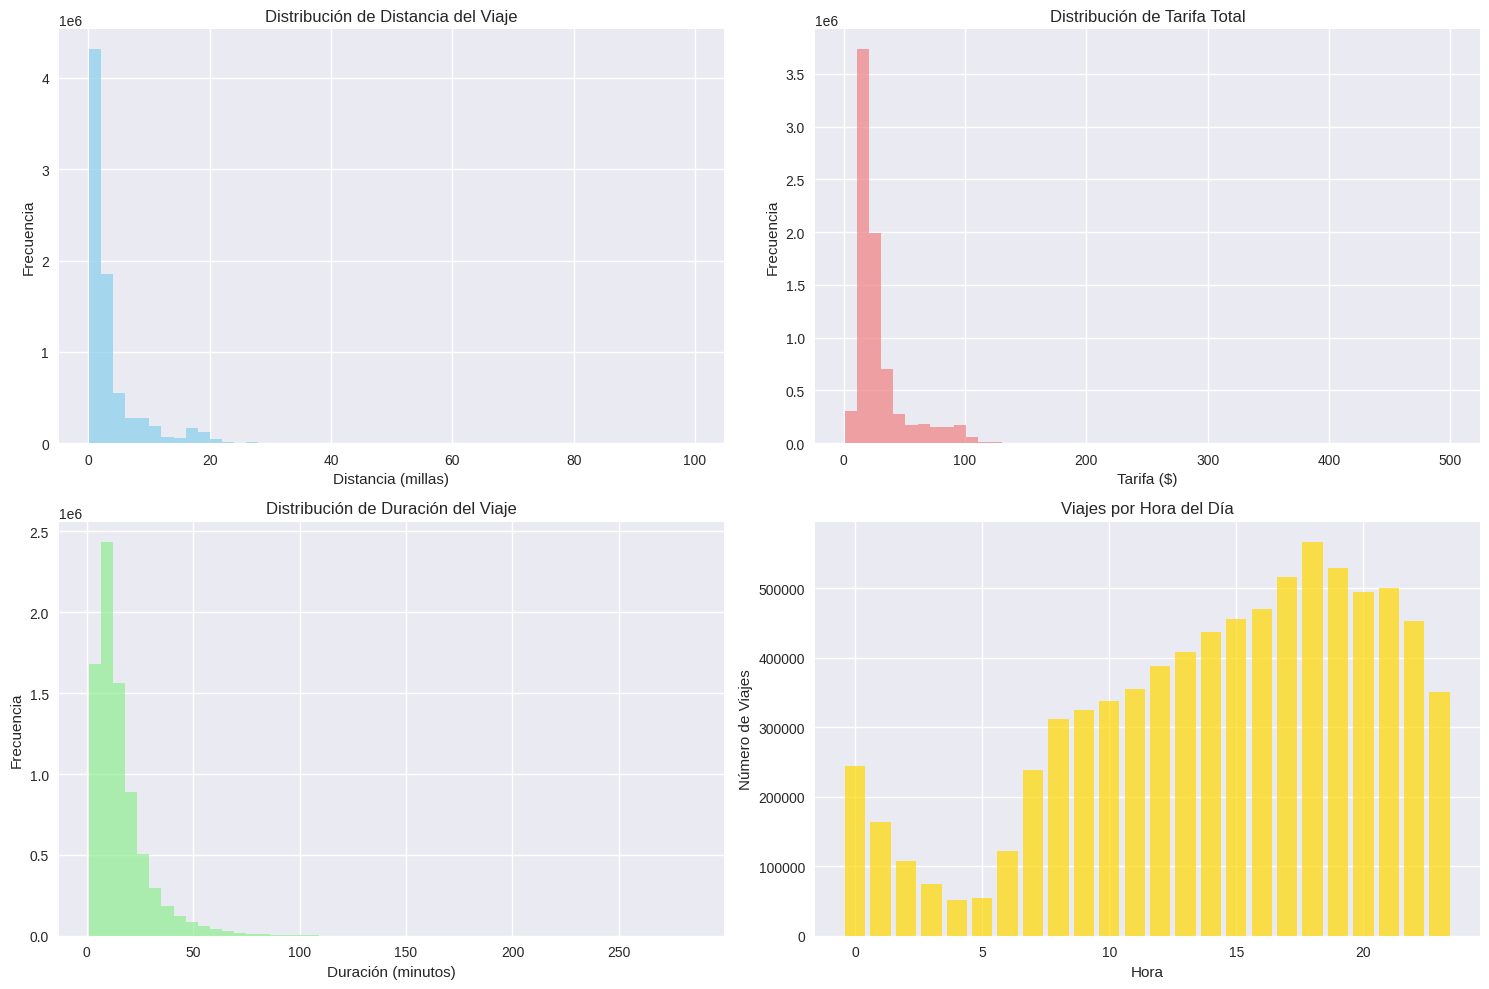

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de distancia del viaje
axes[0,0].hist(df_clean['trip_distance'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribución de Distancia del Viaje')
axes[0,0].set_xlabel('Distancia (millas)')
axes[0,0].set_ylabel('Frecuencia')

# Distribución de tarifa total
axes[0,1].hist(df_clean['total_amount'], bins=50, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Distribución de Tarifa Total')
axes[0,1].set_xlabel('Tarifa ($)')
axes[0,1].set_ylabel('Frecuencia')

# Distribución de duración del viaje
df_clean['trip_duration'] = (df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']).dt.total_seconds() / 60
axes[1,0].hist(df_clean['trip_duration'], bins=50, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Distribución de Duración del Viaje')
axes[1,0].set_xlabel('Duración (minutos)')
axes[1,0].set_ylabel('Frecuencia')

# Viajes por hora del día
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour
hourly_trips = df_clean.groupby('pickup_hour').size()
axes[1,1].bar(hourly_trips.index, hourly_trips.values, alpha=0.7, color='gold')
axes[1,1].set_title('Viajes por Hora del Día')
axes[1,1].set_xlabel('Hora')
axes[1,1].set_ylabel('Número de Viajes')

plt.tight_layout()
plt.show()

## Machine Learning

### Preparativos

#### Preparación de Datos para Machine Learning

In [14]:
def prepare_ml_data(df):
    """
    Prepara los datos para los modelos de Machine Learning
    """
    # Seleccionar características numéricas y categóricas
    numeric_features = ['trip_distance', 'fare_amount', 'tip_amount', 'pickup_hour',
                       'pickup_day', 'pickup_month', 'pickup_weekday', 'pickup_weekend',
                       'trip_duration', 'avg_speed', 'tip_percentage', 'passenger_count',
                       'pickup_zone', 'dropoff_zone']

    categorical_features = ['rush_hour_category', 'payment_type']

    # Crear dataset para ML
    ml_data = df[numeric_features + categorical_features + ['total_amount', 'long_trip']].copy()

    # Manejar valores faltantes
    ml_data = ml_data.fillna(ml_data.median(numeric_only=True))

    # Codificar variables categóricas
    le_rush = LabelEncoder()
    ml_data['rush_hour_encoded'] = le_rush.fit_transform(ml_data['rush_hour_category'].astype(str))

    le_payment = LabelEncoder()
    ml_data['payment_type_encoded'] = le_payment.fit_transform(ml_data['payment_type'].astype(str))

    # Features finales para los modelos
    feature_columns = numeric_features + ['rush_hour_encoded', 'payment_type_encoded']

    return ml_data, feature_columns, le_rush, le_payment

Preparamos los datos

In [16]:
ml_data, feature_columns, le_rush, le_payment = prepare_ml_data(df_clean)

print("Dataset preparado para ML:")
print(f"Forma: {ml_data.shape}")
print(f"Características: {len(feature_columns)}")

Dataset preparado para ML:
Forma: (7954107, 20)
Características: 16


#### División de Datos (70-15-15)

In [17]:
def split_data(ml_data, feature_columns, target_regression, target_classification):
    """
    Divide los datos en entrenamiento, validación y prueba (70-15-15)
    """
    X = ml_data[feature_columns]
    y_reg = ml_data[target_regression]
    y_clf = ml_data[target_classification]

    # Primera división: 70% entrenamiento, 30% temporal
    X_train, X_temp, y_reg_train, y_reg_temp, y_clf_train, y_clf_temp = train_test_split(
        X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=y_clf
    )

    # Segunda división: dividir el 30% en 15% validación y 15% prueba
    X_val, X_test, y_reg_val, y_reg_test, y_clf_val, y_clf_test = train_test_split(
        X_temp, y_reg_temp, y_clf_temp, test_size=0.5, random_state=42, stratify=y_clf_temp
    )

    print("División de datos completada:")
    print(f"Entrenamiento: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Validación: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Prueba: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

    return X_train, X_val, X_test, y_reg_train, y_reg_val, y_reg_test, y_clf_train, y_clf_val, y_clf_test

Dividimos los datos en entrenamiento-validación-prueba

In [18]:
X_train, X_val, X_test, y_reg_train, y_reg_val, y_reg_test, y_clf_train, y_clf_val, y_clf_test = split_data(
    ml_data, feature_columns, 'total_amount', 'long_trip'
)

División de datos completada:
Entrenamiento: 5567874 (70.0%)
Validación: 1193116 (15.0%)
Prueba: 1193117 (15.0%)


### Modelo de Regresión: Predicción de Tarifa Total

Modelos de Regresión (Predicción de Tarifa):
* **Random Forest:** Generalmente mejor rendimiento debido a su capacidad de capturar relaciones no lineales
* **Regresión Lineal:** Modelo baseline, útil para interpretabilidad




In [2]:
class TaxiFarePredictionModel:
    """
    Modelo para predecir la tarifa total de viajes en taxi
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.linear_model = LinearRegression()
        self.rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.models = {}

    def train(self, X_train, y_train, X_val, y_val):
        """Entrena múltiples modelos de regresión"""

        # Escalar características
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        models_to_train = {
            'Linear Regression': self.linear_model,
            'Random Forest': self.rf_model
        }

        print("=== ENTRENANDO MODELOS DE REGRESIÓN ===")

        for name, model in models_to_train.items():
            print(f"\nEntrenando {name}...")

            if name == 'Linear Regression':
                model.fit(X_train_scaled, y_train)
                y_pred_train = model.predict(X_train_scaled)
                y_pred_val = model.predict(X_val_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_val = model.predict(X_val)

            # Métricas de entrenamiento
            train_mse = mean_squared_error(y_train, y_pred_train)
            train_r2 = r2_score(y_train, y_pred_train)
            train_mae = mean_absolute_error(y_train, y_pred_train)

            # Métricas de validación
            val_mse = mean_squared_error(y_val, y_pred_val)
            val_r2 = r2_score(y_val, y_pred_val)
            val_mae = mean_absolute_error(y_val, y_pred_val)

            self.models[name] = {
                'model': model,
                'train_metrics': {'MSE': train_mse, 'R²': train_r2, 'MAE': train_mae},
                'val_metrics': {'MSE': val_mse, 'R²': val_r2, 'MAE': val_mae}
            }

            print(f"Métricas de Entrenamiento - MSE: {train_mse:.2f}, R²: {train_r2:.3f}, MAE: {train_mae:.2f}")
            print(f"Métricas de Validación - MSE: {val_mse:.2f}, R²: {val_r2:.3f}, MAE: {val_mae:.2f}")

    def evaluate_on_test(self, X_test, y_test):
        """Evalúa los modelos en el conjunto de prueba"""

        print("\n=== EVALUACIÓN EN CONJUNTO DE PRUEBA (REGRESIÓN) ===")

        X_test_scaled = self.scaler.transform(X_test)

        for name, model_info in self.models.items():
            model = model_info['model']

            if name == 'Linear Regression':
                y_pred_test = model.predict(X_test_scaled)
            else:
                y_pred_test = model.predict(X_test)

            test_mse = mean_squared_error(y_test, y_pred_test)
            test_r2 = r2_score(y_test, y_pred_test)
            test_mae = mean_absolute_error(y_test, y_pred_test)

            print(f"\n{name}:")
            print(f"  MSE: {test_mse:.2f}")
            print(f"  R²: {test_r2:.3f}")
            print(f"  MAE: {test_mae:.2f}")
            print(f"  RMSE: {np.sqrt(test_mse):.2f}")

In [4]:
# Entrenar modelo de regresión
regression_model = TaxiFarePredictionModel()
regression_model.train(X_train, y_reg_train, X_val, y_reg_val)
regression_model.evaluate_on_test(X_test, y_reg_test)

NameError: name 'StandardScaler' is not defined

### Modelo de Clasificación: Predicción de Viajes Largos

Modelos de Clasificación (Predicción de Viajes Largos):
* **Random Forest:** Mayor capacidad predictiva para patrones complejos
* **Regresión Logística:** Modelo interpretable con buenos resultados

In [ ]:
class TaxiTripClassificationModel:
    """
    Modelo para clasificar si un viaje será largo (>30 minutos)
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.logistic_model = LogisticRegression(random_state=42, max_iter=1000)
        self.rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.models = {}

    def train(self, X_train, y_train, X_val, y_val):
        """Entrena múltiples modelos de clasificación"""

        # Escalar características
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        models_to_train = {
            'Logistic Regression': self.logistic_model,
            'Random Forest': self.rf_model
        }

        print("=== ENTRENANDO MODELOS DE CLASIFICACIÓN ===")

        for name, model in models_to_train.items():
            print(f"\nEntrenando {name}...")

            if name == 'Logistic Regression':
                model.fit(X_train_scaled, y_train)
                y_pred_train = model.predict(X_train_scaled)
                y_pred_val = model.predict(X_val_scaled)
                y_prob_val = model.predict_proba(X_val_scaled)[:, 1]
            else:
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_val = model.predict(X_val)
                y_prob_val = model.predict_proba(X_val)[:, 1]

            # Métricas de entrenamiento
            train_accuracy = accuracy_score(y_train, y_pred_train)
            train_precision = precision_score(y_train, y_pred_train)
            train_recall = recall_score(y_train, y_pred_train)
            train_f1 = f1_score(y_train, y_pred_train)

            # Métricas de validación
            val_accuracy = accuracy_score(y_val, y_pred_val)
            val_precision = precision_score(y_val, y_pred_val)
            val_recall = recall_score(y_val, y_pred_val)
            val_f1 = f1_score(y_val, y_pred_val)

            self.models[name] = {
                'model': model,
                'train_metrics': {
                    'Accuracy': train_accuracy, 'Precision': train_precision,
                    'Recall': train_recall, 'F1': train_f1
                },
                'val_metrics': {
                    'Accuracy': val_accuracy, 'Precision': val_precision,
                    'Recall': val_recall, 'F1': val_f1
                }
            }

            print(f"Entrenamiento - Acc: {train_accuracy:.3f}, Prec: {train_precision:.3f}, Rec: {train_recall:.3f}, F1: {train_f1:.3f}")
            print(f"Validación - Acc: {val_accuracy:.3f}, Prec: {val_precision:.3f}, Rec: {val_recall:.3f}, F1: {val_f1:.3f}")

    def evaluate_on_test(self, X_test, y_test):
        """Evalúa los modelos en el conjunto de prueba"""

        print("\n=== EVALUACIÓN EN CONJUNTO DE PRUEBA (CLASIFICACIÓN) ===")

        X_test_scaled = self.scaler.transform(X_test)

        for name, model_info in self.models.items():
            model = model_info['model']

            if name == 'Logistic Regression':
                y_pred_test = model.predict(X_test_scaled)
            else:
                y_pred_test = model.predict(X_test)

            test_accuracy = accuracy_score(y_test, y_pred_test)
            test_precision = precision_score(y_test, y_pred_test)
            test_recall = recall_score(y_test, y_pred_test)
            test_f1 = f1_score(y_test, y_pred_test)

            print(f"\n{name}:")
            print(f"  Accuracy: {test_accuracy:.3f}")
            print(f"  Precision: {test_precision:.3f}")
            print(f"  Recall: {test_recall:.3f}")
            print(f"  F1-Score: {test_f1:.3f}")

            # Matriz de confusión
            cm = confusion_matrix(y_test, y_pred_test)
            print(f"  Matriz de Confusión:")
            print(f"    [[{cm[0,0]}, {cm[0,1]}],")
            print(f"     [{cm[1,0]}, {cm[1,1]}]]")

In [ ]:
# Entrenar modelo de clasificación
classification_model = TaxiTripClassificationModel()
classification_model.train(X_train, y_clf_train, X_val, y_clf_val)
classification_model.evaluate_on_test(X_test, y_clf_test)

## Visualización de Resultados

In [ ]:
# Función para visualizar importancia de características (Random Forest)
def plot_feature_importance():
    """Visualiza la importancia de las características"""

    # Importancia para regresión
    rf_reg = regression_model.models['Random Forest']['model']
    importance_reg = rf_reg.feature_importances_

    # Importancia para clasificación
    rf_clf = classification_model.models['Random Forest']['model']
    importance_clf = rf_clf.feature_importances_

    # Crear visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico de regresión
    indices_reg = np.argsort(importance_reg)[::-1][:10]
    ax1.bar(range(10), importance_reg[indices_reg])
    ax1.set_title('Importancia de Características - Regresión (Tarifa)')
    ax1.set_xlabel('Características')
    ax1.set_ylabel('Importancia')
    ax1.set_xticks(range(10))
    ax1.set_xticklabels([feature_columns[i] for i in indices_reg], rotation=45)

    # Gráfico de clasificación
    indices_clf = np.argsort(importance_clf)[::-1][:10]
    ax2.bar(range(10), importance_clf[indices_clf])
    ax2.set_title('Importancia de Características - Clasificación (Viaje Largo)')
    ax2.set_xlabel('Características')
    ax2.set_ylabel('Importancia')
    ax2.set_xticks(range(10))
    ax2.set_xticklabels([feature_columns[i] for i in indices_clf], rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
# Visualización de distribución de predicciones vs realidad
def plot_predictions_vs_actual():
    """Compara predicciones con valores reales"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Predicciones de regresión
    rf_reg_model = regression_model.models['Random Forest']['model']
    y_pred_reg = rf_reg_model.predict(X_test)

    axes[0].scatter(y_reg_test, y_pred_reg, alpha=0.5)
    axes[0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
    axes[0].set_xlabel('Tarifa Real ($)')
    axes[0].set_ylabel('Tarifa Predicha ($)')
    axes[0].set_title('Predicción de Tarifa: Real vs Predicha')

    # Distribución de clases en clasificación
    rf_clf_model = classification_model.models['Random Forest']['model']
    y_pred_clf = rf_clf_model.predict(X_test)

    from collections import Counter
    real_counts = Counter(y_clf_test)
    pred_counts = Counter(y_pred_clf)

    x_pos = [0, 1]
    axes[1].bar([x - 0.2 for x in x_pos], [real_counts[0], real_counts[1]],
                width=0.4, label='Real', alpha=0.7)
    axes[1].bar([x + 0.2 for x in x_pos], [pred_counts[0], pred_counts[1]],
                width=0.4, label='Predicho', alpha=0.7)
    axes[1].set_xlabel('Tipo de Viaje')
    axes[1].set_ylabel('Cantidad')
    axes[1].set_title('Clasificación: Distribución Real vs Predicha')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(['Viaje Corto', 'Viaje Largo'])
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Visualizar importancia de características
plot_feature_importance()

In [ ]:
# Mostrar comparación de predicciones
plot_predictions_vs_actual()